In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import os 
import math


### 1) Implement a basic bag of visual words model

#### Read Data

In [2]:
def load_data(path):
    data = []
    
    for label in os.listdir(path):
        
        if os.path.isdir(path+label):
            for image in os.listdir(path+label+'/'):
                if image.split('.')[1] == 'jpg':
                    
                    img = cv2.imread(path+label+'/'+image , 0)
                    img = cv2.resize(img ,(150,150))

                    data.append([img ,label])
    
    return data        

In [3]:
train_data = load_data('../dataset/SUN_data/train/')
test_data = load_data('../dataset/SUN_data/test/')

#### Helper Funcitons 

In [4]:
def get_labels(data):
    l = []
    
    for i in data:
        l.append(i[1])
    
    l = list(set(l))
    label_mapping = {}
    
    c = 0
    for i in range( len(l)):
        label_mapping[ l[i]] = c
        c+=1
    
    return label_mapping

In [5]:
def get_descriptors(train_data ,sift_features ,step ,sift_variant ):
    
    sift=cv2.xfeatures2d.SIFT_create(sift_features)
    
    des_list = []
    des_images = []
    
    y = []
    
    count = 0
    
    for i in train_data:
        img = i[0]
        label = i[1]
        
        if sift_variant == 'sift':
            kp , des = sift.detectAndCompute(img,None)
        else:
            kp , des = Dsift(img , step)
            
        des_images.append(des)
        
        for j in des:
            des_list.append(j)
        
        y.append(label)
        
    return des_list ,des_images , y

In [6]:
def train_kmeans(des ,clusters):
    
    kmeans = MiniBatchKMeans(n_clusters=clusters ,random_state=0)
    #kmeans = KMeans(n_clusters=150 ,random_state=0)
    kmeans.fit(des)
    
    return kmeans

In [7]:
def get_histograms(descriptors , kmeans ,clusters ):
    
    histograms = []
    
    for img_des in descriptors:
        
        temp_hist = np.zeros( clusters )
        
        for i in img_des:
            idx = kmeans.predict([i])
            temp_hist[ idx ] += 1
            
        histograms.append(temp_hist)
    
    histograms = np.array(histograms,dtype='float')
    
    return histograms

#### Train BOW

In [8]:
def BOW_train(train_data ,clusters , sift_variant , step ,sift_features , reg_para  , svm_iter ,hist_norm):
    
    label_mapping = get_labels(train_data)
    
    des_list ,des_images , y = get_descriptors( train_data ,sift_features ,step, sift_variant )
    
    des_list = np.array(des_list ,dtype = 'float')
    
    kmeans = train_kmeans( des_list ,clusters)
    
    hists = get_histograms(des_images , kmeans ,clusters)
    
    stds=StandardScaler().fit(hists)
    
    if hist_norm == True:
        hists=stds.transform(hists)
    
    clf=OneVsRestClassifier(LinearSVC(C=reg_para,max_iter=svm_iter)).fit(hists,y)
    
    return kmeans , stds ,clf

#### Test BOW

In [9]:
def orig_labels(test_data):
    l = []
    
    for i in test_data:
        l.append(i[1])
    
    return l

In [10]:
def BOW_test(test_data , kmeans ,scaling , svm_clf ,clusters , sift_variant ,step ,sift_features ,hist_norm ,confusion_mat ,show_img):
    
    orig_y = orig_labels(test_data)
    
    des_list ,des_images , y = get_descriptors( test_data ,sift_features ,step , sift_variant )
    
    hists = get_histograms(des_images , kmeans , clusters)
    if hist_norm == True:
        hists = scaling.transform(hists)
    
    pred = svm_clf.predict(hists)
    
    print('\t Accuracy : ' + str(accuracy_score(orig_y,pred)) )
    
    if show_img == True:
        return orig_y , pred
        
    if confusion_mat == True:
        return confusion_matrix(orig_y, pred) ,accuracy_score(orig_y,pred)
    else:
        return accuracy_score(orig_y,pred)

In [11]:
def BOW( train_path , test_path , clusters=150 , sift_variant = 'sift',step = 5,sift_features=200 , reg_para = 1.0 , svm_iter=5000 ,hist_norm=True ,confusion_mat=False ,show_img=False):
    
    train_data = load_data(train_path)
    test_data = load_data(test_path)
    
    kmeans , scale_transform , svm_clf = BOW_train(train_data ,clusters ,sift_variant ,step,sift_features , reg_para  , svm_iter , hist_norm )
    
    return BOW_test(test_data ,kmeans , scale_transform , svm_clf ,clusters , sift_variant ,step , sift_features ,hist_norm ,confusion_mat ,show_img )

In [99]:
BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' )

train kmeans
Train SVC
Accuracy : 0.4375


### 2) BOW With Dense SIFT

#### Desnse SIFT

In [12]:
def Dsift(img ,step):
    step_size = step
    
    kps = [cv2.KeyPoint(x, y, step_size) for y in range(0, img.shape[0], step_size) 
                                    for x in range(0, img.shape[1], step_size)]
    

    sift = cv2.xfeatures2d.SIFT_create()
    return sift.compute(img,kps)

In [96]:
BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift')
    

train kmeans
Train SVC
Accuracy : 0.5125


#### Number Of Clusters Vs Accuracy 

In [ ]:
cls_num = [10 ,50 ,100 ,150 ,200 ,500]
acc = []

for i in cls_num:
    print(' Number of clusters : ' + str(i))
    acc.append(BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , clusters=i))

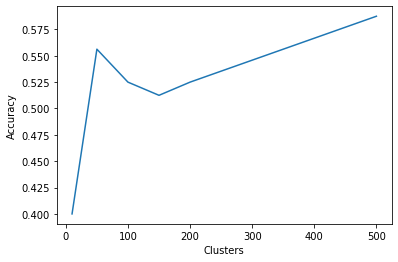

In [108]:
plt.xlabel("Clusters")
plt.ylabel("Accuracy")
plt.plot(cls_num , acc)
plt.show()

#### Number of SIFT Descriptors ( Step size ) Vs Accuracy 

In [ ]:
steps = [5 ,10 ,20 ,50 ,100]
acc = []

for i in steps:
    print(' Step Size : ' + str(i))
    acc.append(BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , step=i))

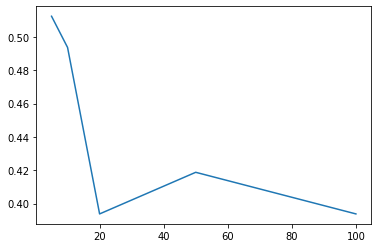

In [112]:

plt.xlabel("Step Size")
plt.ylabel("Accuracy")
plt.plot(steps , acc)
plt.show()

#### Number of SVM Iteration Vs Accuracy 

In [ ]:
svm_iters = [500 ,1000 ,2000 ,5000 ,10000]
acc = []

for i in svm_iters :
    print('Number of Iters  : ' + str(i))
    acc.append(BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , svm_iter=i))

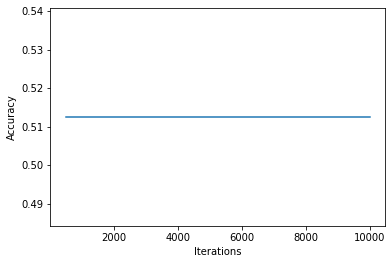

In [114]:
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(svm_iters , acc)
plt.show()

### 3) One Vs All SVM and Tuning Perameter Lambda

In [ ]:
lambda_val = [0.1 , 0.3 ,0.5 , 1 ,1.5 ,2]

for i in lambda_val :
    print('Lambda  : ' + str(i))
    acc.append(BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , reg_para=i))

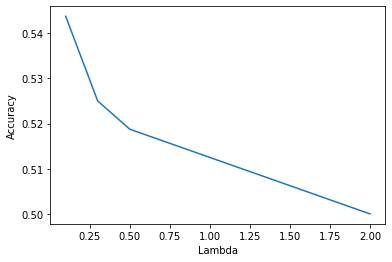

In [122]:
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.plot(lambda_val , acc)
plt.show()

In [123]:
lambda_val = 0.1
clus = 500
step_size = 5
iters = 5000

BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , reg_para=lambda_val ,clusters = clus ,step = step_size , svm_iter=iters)

	 Accuracy : 0.6


0.6

In [13]:
lambda_val = 0.01
clus = 500
step_size = 5
iters = 5000

BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , reg_para=lambda_val ,clusters = clus ,step = step_size , svm_iter=iters)

	 Accuracy : 0.6625


0.6625

### 4) Confusion Matrix

##### With Normlized Histograms

In [157]:
confusion_mat ,acc = BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , reg_para=lambda_val ,clusters = clus ,step = step_size , svm_iter=iters ,hist_norm=True ,confusion_mat=True)

	 Accuracy : 0.6


<AxesSubplot:>

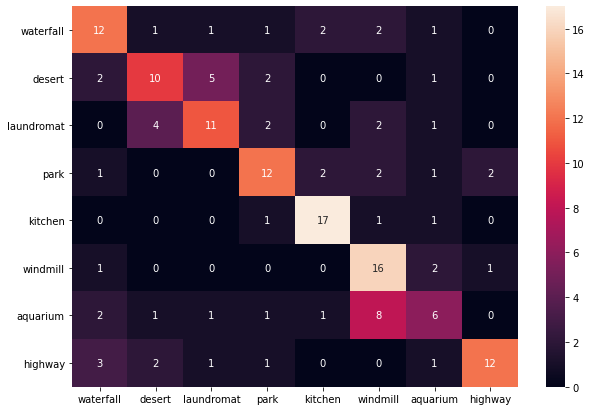

In [163]:
d = get_labels(train_data)

labels = d.keys()

df_cm = pd.DataFrame(confusion_mat, index = labels,columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Without Normlized Histograms 

In [166]:
confusion_mat ,acc = BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , reg_para=lambda_val ,clusters = clus ,step = step_size , svm_iter=iters ,hist_norm=False ,confusion_mat=True)

	 Accuracy : 0.5875


<AxesSubplot:>

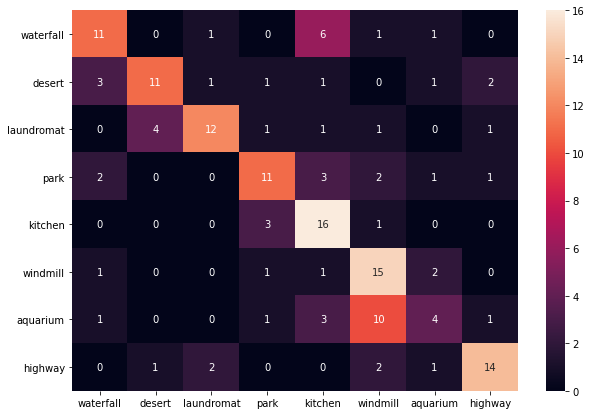

In [167]:
d = get_labels(train_data)

labels = d.keys()

df_cm = pd.DataFrame(confusion_mat, index = labels,columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

#### Correct / Incorrect Classified Images 

In [171]:
true_labs ,pred_labs = BOW('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' ,sift_variant='dsift' , reg_para=lambda_val ,clusters = clus ,step = step_size , svm_iter=iters ,show_img=True)

	 Accuracy : 0.6


In [177]:
def saprate_images(test_data , pred_labs ):
    correct = {'windmill':[] , 'kitchen':[] ,'desert':[] ,'park':[] ,'laundromat':[] ,'waterfall':[] ,'highway':[] ,'aquarium':[]}
    incorrect = {'windmill':[] , 'kitchen':[] ,'desert':[] ,'park':[] ,'laundromat':[] ,'waterfall':[] ,'highway':[] ,'aquarium':[]}
    
    for i in range(len(test_data)):
        img = test_data[i][0]
        orig = test_data[i][1] 
        pred = pred_labs[i] 
        
        if orig == pred:
            correct[ orig ].append(img)
        else:
            incorrect[ orig ].append([img,pred])
    
    return correct , incorrect

correct_img , incorrect_img = saprate_images(test_data , pred_labs )

#### Correct classified Images 

In [186]:
def plot_correct(img_list):
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(cv2.cvtColor(img_list[0] ,cv2.COLOR_BGR2RGB))
    axarr[1].imshow(cv2.cvtColor(img_list[1] ,cv2.COLOR_BGR2RGB))
    axarr[2].imshow(cv2.cvtColor(img_list[2] ,cv2.COLOR_BGR2RGB))
    axarr[3].imshow(cv2.cvtColor(img_list[3] ,cv2.COLOR_BGR2RGB))

Windmill


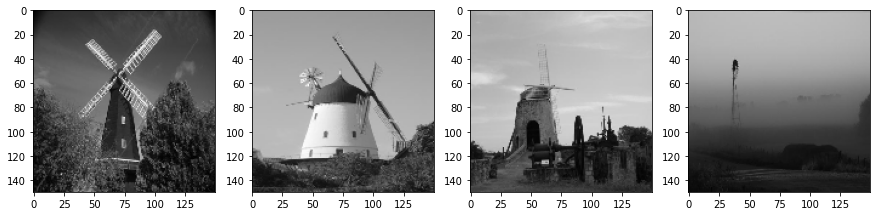

In [193]:
print('Windmill')
plot_correct(correct_img['windmill'])

Kitchen


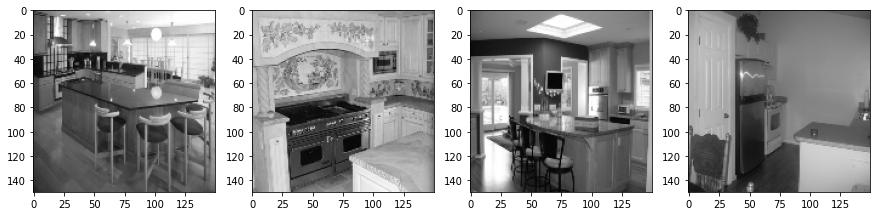

In [194]:
print('Kitchen')
plot_correct(correct_img['kitchen'])

Waterfall


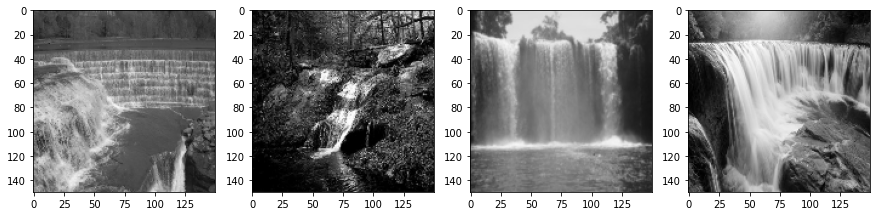

In [195]:
print('Waterfall')
plot_correct(correct_img['waterfall'])

#### Incorrect Classified Images 

In [205]:
def plot_incorrect(img_list):
    f, axarr = plt.subplots(1,4)
    
    axarr[0].set_title('Predicted : '+img_list[0][1])
    axarr[0].imshow(cv2.cvtColor(img_list[0][0] ,cv2.COLOR_BGR2RGB))
    
    axarr[1].set_title('Predicted : '+img_list[1][1])
    axarr[1].imshow(cv2.cvtColor(img_list[1][0] ,cv2.COLOR_BGR2RGB))
    
    axarr[2].set_title('Predicted : '+img_list[2][1])
    axarr[2].imshow(cv2.cvtColor(img_list[2][0] ,cv2.COLOR_BGR2RGB))
    
    axarr[3].set_title('Predicted : '+img_list[3][1])
    axarr[3].imshow(cv2.cvtColor(img_list[3][0] ,cv2.COLOR_BGR2RGB))

Original Class : Windmill


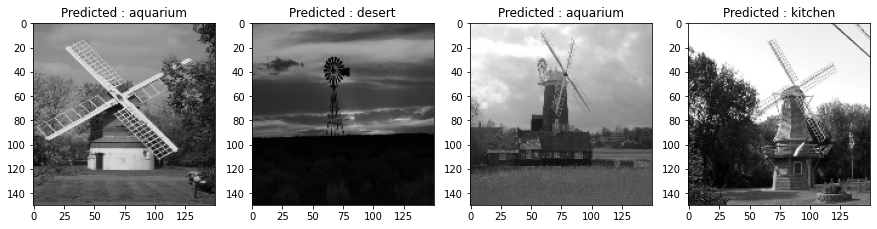

In [206]:
print('Original Class : Windmill')
plot_incorrect( incorrect_img['windmill'] )

Original Class : Waterfall


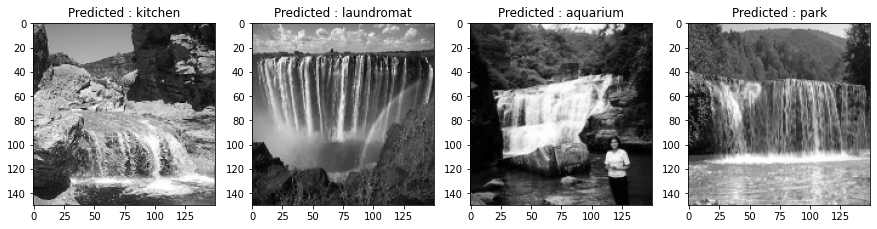

In [207]:
print('Original Class : Waterfall')
plot_incorrect( incorrect_img['waterfall'] )

Original Class : Desert


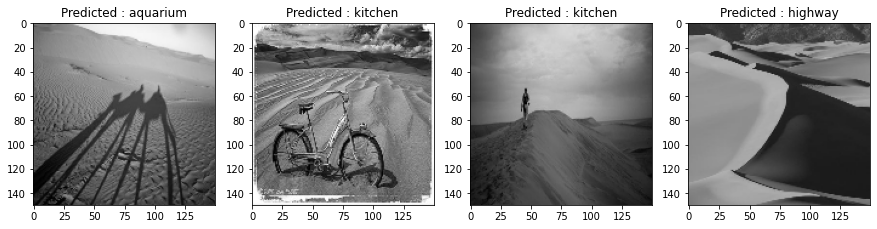

In [208]:
print('Original Class : Desert')
plot_incorrect( incorrect_img['desert'] )

## 5) Bonus : Spatial Pyramid Matching 

In [252]:
def SPM_train(train_data ,clusters ,step  ,reg_para ,levels=2 ):
    
    des_list ,des_images , y = get_descriptors( train_data ,step)
    
    des_list = np.array(des_list ,dtype = 'float')
    
    print('Train Kmeans')
    kmeans = train_kmeans( des_list ,clusters)
    
    print('Get Histograms')
    hists = SPM_histograms(train_data, kmeans ,clusters ,step , levels )
    
    stds=StandardScaler().fit(hists)
    hists=stds.transform(hists)
    
    print('Train SVM')
    clf=OneVsRestClassifier(LinearSVC(C=reg_para,max_iter=5000)).fit(hists,y)
    
    return kmeans , stds ,clf

In [253]:
def SPM_test(test_data , kmeans ,scaling , svm_clf ,clusters ,step ,levels = 2):
    
    print('Test')
    orig_y = orig_labels(test_data)
    
    hists = SPM_histograms(test_data , kmeans , clusters , step ,levels)
    
    hists = scaling.transform(hists)
    
    print('Predict')
    pred = svm_clf.predict(hists)
    
    print('\t Accuracy : ' + str(accuracy_score(orig_y,pred)) )
    

In [254]:
def orig_labels(test_data):
    l = []
    
    for i in test_data:
        l.append(i[1])
    
    return l

In [255]:
def get_descriptors(train_data ,step ):
    
    des_list = []
    des_images = []
    
    y = []
    
    count = 0
    
    for i in train_data:
        img = i[0]
        label = i[1]

        kp , des = Dsift(img , step)
            
        des_images.append(des)
        
        for j in des:
            des_list.append(j)
        
        y.append(label)
        
    return des_list ,des_images , y

In [256]:
def Dsift(img ,step):
    step_size = step
    
    kps = [cv2.KeyPoint(x, y, step_size) for y in range(0, img.shape[0], step_size) 
                                    for x in range(0, img.shape[1], step_size)]
    

    sift = cv2.xfeatures2d.SIFT_create()
    return sift.compute(img,kps)

In [257]:
def train_kmeans(des ,clusters):
    
    kmeans = MiniBatchKMeans(n_clusters=clusters ,random_state=0)
    #kmeans = KMeans(n_clusters=150 ,random_state=0)
    kmeans.fit(des)
    
    return kmeans

In [294]:
def SPM_histograms( train_data , kmeans ,clusters ,step ,levels):
    hists = []
    
    for i in train_data:
        img = i[0]
        
        hists.append(spm_feature(img , kmeans ,clusters , levels ,step ))
        
        
    hists = np.array(hists,dtype='float')
    
    return hists
        
    

In [295]:
def spm_feature(img , kmeans , clusters , levels ,step ):
    width = img.shape[1]
    hight = img.shape[0]
    
    full_hist = []
    for lev in range(levels + 1):
        
        w_stride = math.floor(width / (2**lev))
        h_stride = math.floor(hight / (2**lev))
        
        h_start = 0
        w_start = 0
        
        for i in range(1 , 2**lev + 1):
            w_start = 0
            for j in range( 1 , 2**lev + 1):
                
                sub_img = img[ h_start : h_start+h_stride , w_start : w_start+w_stride ]
#                 print(sub_img.shape , lev)
#                 print( h_start , h_start+h_stride , w_start , w_start+w_strideide)
#                 print()
                kp , des = Dsift(sub_img ,step)
                
                temp_hist = sub_hist( des ,kmeans , clusters)
                
                weights = [ 1/4 , 1/4 ,1/2 ]
                lev_weight = weights[lev]
                
                temp_hist = lev_weight*temp_hist
                
                if len(full_hist)==0:
                    full_hist = temp_hist
                else:
                    full_hist = np.concatenate((full_hist, temp_hist), axis=None)
                
                w_start += w_stride
            h_start += h_stride
    
    return full_hist

In [296]:
def sub_hist(descriptors , kmeans ,clusters ):
            
    hist = np.zeros( clusters )

    for i in descriptors:
        idx = kmeans.predict([i])
        hist[ idx ] += 1

    return hist

In [297]:
def BOW_SPM( train_path , test_path , clusters=500 ,step = 5, reg_para = 0.01 ):
    
    train_data = load_data(train_path)
    test_data = load_data(test_path)
    
    kmeans , scale_transform , svm_clf = SPM_train(train_data ,clusters ,step , reg_para )
    
    return SPM_test(test_data ,kmeans , scale_transform , svm_clf ,clusters ,step)

In [298]:
BOW_SPM('../dataset/SUN_data/train/' ,'../dataset/SUN_data/test/' )

Train Kmeans
Get Histograms
Train SVM
Test
Predict
	 Accuracy : 0.6875
